In [24]:
from init_nb import init_notebook
config = init_notebook()
from pathlib import Path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bold_dementia.utils.configuration import get_config
from bold_dementia.utils.saving import save_run
from bold_dementia.stats.univariate import make_fc_data, run_test, export_results, merge_configs
from bold_dementia.connectivity import reshape_pvalues, plot_matrix, Atlas


random.seed(config["seed"])

N = 100

In [25]:
maps_path = Path(
    "/bigdata/jlegrand/data/Memento/output/connectivity/atlas-msdl_merged"
)
model_specs_path = Path(
    "/homes_unix/jlegrand/AD-prediction/LM_specs/OLS_cenanom.yml"
)
    
maps_specs = get_config(maps_path / "parameters.yml")
model_specs = get_config(model_specs_path)
print(model_specs)

df, edges, parameters = make_fc_data(maps_path, maps_specs, model_specs)
print(df.head())


{'NAME': 'ols-cenanom', 'RHS_FORMULA': 'AD + scale(current_scan_age) + SEX + NIVETUD + scale(`total intracranial`) + CEN_ANOM', 'GROUPS': None}
   R Aud_L Aud  Striate_L Aud  Striate_R Aud  L DMN_L Aud  L DMN_R Aud  \
0     0.498581      -0.118252      -0.058593     0.015841    -0.000683   
1     0.479843      -0.286632      -0.244602    -0.258216     0.131136   
2     0.849180       0.163169       0.126087     0.195107     0.147975   
3     0.761959      -0.029705       0.036802    -0.168387    -0.019521   
4     0.654926      -0.090044       0.055118    -0.023889    -0.020417   

   L DMN_Striate  Med DMN_L Aud  Med DMN_R Aud  Med DMN_Striate  \
0      -0.036538      -0.068993       0.010222         0.106694   
1      -0.119821      -0.131005      -0.188868         0.068698   
2       0.392752       0.331446       0.274524         0.504498   
3       0.330143       0.114906       0.244550         0.515841   
4       0.205834       0.138110       0.172346         0.223546   

   Med D

In [26]:
idx_range = list(range(len(df)))
permutation_scheme = [
    random.sample(idx_range, k=len(idx_range)) for _ in range(N)
]

Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 240 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    6.0s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.2s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 714 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    2.9s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 714 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.0s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.0s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    2.9s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.1s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.4s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.1s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.2s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 707 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.0s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.1s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.4s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 714 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    2.9s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.1s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.2s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.4s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.2s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.2s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.2s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.5s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.4s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.1s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.4s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.1s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 714 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    2.9s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 726 out of 741 | elapsed:    3.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 714 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.0s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.4s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.6s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.2s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.4s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.6s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.6s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 726 out of 741 | elapsed:    3.4s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.5s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.4s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  35 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.4s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.6s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.2s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 726 out of 741 | elapsed:    3.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.1s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.2s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.4s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.4s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.5s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 726 out of 741 | elapsed:    3.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.1s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.5s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.5s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.2s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 726 out of 741 | elapsed:    3.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.5s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.4s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.4s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 714 tasks      | elapsed:    2.8s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.0s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.2s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.1s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 726 out of 741 | elapsed:    3.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.2s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.4s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.2s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.2s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.6s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.2s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 726 out of 741 | elapsed:    3.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.6s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 726 out of 741 | elapsed:    3.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.1s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.2s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.1s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.5s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.4s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.4s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.4s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.2s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.4s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 714 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.0s finished


Testing on 1310 subjects
89.0 AD
1221 controls


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 504 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 741 out of 741 | elapsed:    3.3s finished


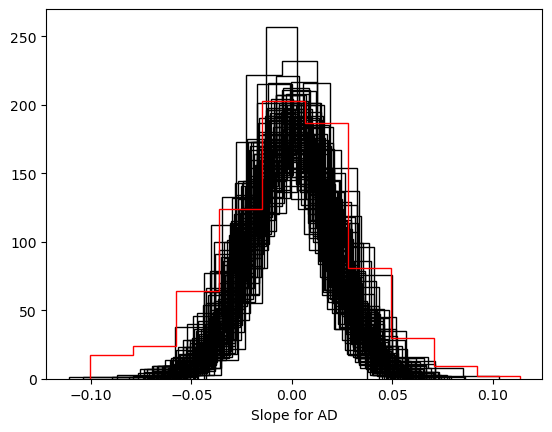

In [27]:
permuted_slopes = []

for permutation in permutation_scheme:
    permuted_target = df.loc[permutation, "AD"].reset_index(drop=True)
    permuted_df = df.copy()
    permuted_df["AD"] = permuted_target
    results = run_test(permuted_df, edges, parameters)
    stats, pvalues = zip(*results)
    permuted_slopes.append(stats)
    plt.hist(stats, histtype="step", color="black")


permuted_target = df.loc[list(range(len(df))), "AD"].reset_index(drop=True)
permuted_df = df.copy()
permuted_df["AD"] = permuted_target
results = run_test(permuted_df, edges, parameters)
stats, pvalues = zip(*results)
plt.hist(stats, histtype="step", color="red")

plt.xlabel("Slope for AD")
plt.show()

In [28]:
permuted_slopes = pd.DataFrame(np.stack(permuted_slopes, axis=1), columns=[f"p_{i}" for i in range(N)])
permuted_slopes["edge"] = edges

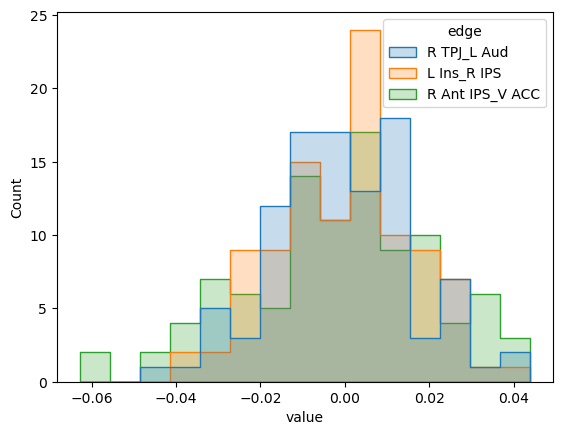

In [29]:

cols = random.sample(edges, k=3)
msk = permuted_slopes.edge.isin(cols)
m = permuted_slopes[msk].melt(id_vars="edge")
sns.histplot(m, x="value", hue="edge", element="step")
plt.show()

In [30]:
params = merge_configs(maps_specs, model_specs)
save_run(
    params,
    lambda obj, path: obj.to_csv(path),
    {"null_distribution.csv": permuted_slopes,},
    dirkey="statresults"
)


PosixPath('/homes_unix/jlegrand/data/Memento/output/statresults/atlas-msdl_merged_ols-cenanom')